#  1st Tutorial on Molecular Dynamics: A Simple MD Code

It is our goal to write a **simple coarse-grained MD Code to simulate a Lennard-Jones (LJ) fluid in the NVE ensemble.** This means we will have simple spherical particles that interact with each other via a LJ potential. The time development of the system, i.e. the movement of these atoms, results from time integrating Newton's equations of motion by using the **Velocity-Verlet algorithm**. NVE means that our system has a constant particle number N, simulation box volume V and total energy E.


## ****Overall aim:**** Complete the code of this simple MD program. 

*You can either start from scratch or use the outlined structure and hints to fill in the gaps. In the end, the code should be able for perform a functional MD simulation and should have some simple capabilities for measurements.*

### 1. Define the basic parameters of the simulation, e.g. number of particles, size of the box, timestep, interaction potential (LJ potential), etc.

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# activate this for interactive plots (zooming, rotation)
#%matplotlib notebook 

# activate this for simple drawn plots (non-interactive)
%matplotlib inline 

# simulation parameters in LJ units
N = 20 # number of particles
L = 10.0 # edge length of a cubic box
nsteps = 50000 # number of time steps
dt = 0.0005 # timestep
m = 1.0 # mass of one particle
V = L*L*L # box volume
rho = 1.0*N/V # density

# define all possible particle pairs (indices)
pairs_global = np.array([(i,j) for i in range(N) for j in range(i)])

# define bonded pairs
bonds = np.array([[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [7,8], [8,9], 
                  [10,11], [11,12], [12,13], [13,14], [14,15], [15,16], [16,17], [17,18], [18,19]], np.int32)

#bonds = np.array([[0,1]], np.int32)


### The Lennard-Jones Potential:

\begin{equation}
U_\mathrm{LJ}(r) = 4 \epsilon \bigg[ \bigg(\frac{\sigma}{r}\bigg)^{12}  - \bigg(\frac{\sigma}{r}\bigg)^{6} \bigg]
\end{equation}
$r$ - distance between particle centers <br>
$\epsilon$ - interaction strength (potential depth) <br>
$\sigma$ - particle "size" (root of the potential)<br>
<br>

In simulations the LJ potential (and its negative first derivate, i.e. the force) is truncated (or cut off) at a certain distance $r$. The reasoning behind this is that the potential is nearly at zero for large enough values of $r$, anyway. When particles further apart than the cutoff distance $r_\mathrm{cut}$ are ignored in the force calculation, a lot of simulation time is saved, while the particle interactions remain realistic.
<br>
<br>

The **typical cutoff distance of the LJ potential in coarse-grained MD is $r_\mathrm{cut} = 2.5$.** In this case the particles have repulsive interactions at very short distances and attractive interactions at intermediate distances. The potential is not only truncated but also shifted along the y-axis: This is neccessary to have zero energy (and zero force) exactly at the cutoff distance: $U_\mathrm{LJ}(r_\mathrm{cut}) \stackrel{!}{=} 0$ and $F(r_\mathrm{cut}) \stackrel{!}{=} 0$. Any nonzero values $U_\mathrm{LJ}(r_\mathrm{cut}), F(r_\mathrm{cut}) \neq 0$ would be a sudden "jump" in the energy (or force) and hence an unphysical artefact.
<br>
<br>

The **shifted, truncated LJ-Potential** is obtained by subtracting the function value at the cutoff:

\begin{equation} U_\mathrm{LJ, cut}(r) = U_\mathrm{LJ}(r) - U_\mathrm{LJ}(r_\mathrm{cut}) \end{equation}

#### Typical values of the cutoff distance $r_\mathrm{cut}$ :

$r_\mathrm{cut,\,short} = \min(U_\mathrm{LJ}(r)) = \sqrt[6]{2} \approx 1.12246$ - "short" cutoff, no attractive part <br>
$r_\mathrm{cut,\, long} = 2.5$ - long cutoff, with attractive part <br>

In [7]:
# Parameters of the LJ potential
rcut = 1.12246
epsilon = 1.0
sigma = 1.0

def U(x):
    """ Lennard-Jones pot. (12-6) to calculate potential energy """
    sx = sigma/x
    sx3 = sx*sx*sx
    sx6 = sx3*sx3
    sx12 =  sx6*sx6
    sc = sigma/rcut
    sc3 = sc*sc*sc
    sc6 = sc3*sc3
    sc12 =  sc6*sc6    
    return 4.*epsilon*(sx12 - sx6) - 4.*epsilon*(sc12 - sc6)

def DU(x):
    """ spatial derivative of the LJ pot. to calculate forces """
    sx = sigma/x
    sx3 = sx*sx*sx
    sx6 = sx3*sx3
    sx12 =  sx6*sx6
    sc = sigma/rcut
    sc3 = sc*sc*sc
    sc6 = sc3*sc3
    sc12 =  sc6*sc6        
    return -24./x*epsilon*(2.*sx12 - sx6)  + 24./rcut*epsilon*(2.*sc12 - sc6)

# some Parameters of harmonic potential
k = 50.0
x0 = 1.0

def HARM(x):
    """Harmonic potential for bonds"""
    return 0.5*k*(x-x0)*(x-x0)

def DHARM(x):
    """Spatial derivative of Harmonic Potential"""
    return k*(x-x0)


# standard parameters of FENE potential (Kremer-Grest model)
k_FENE = 30.0
r0_FENE = 1.5

def FENE(x):
    """FENE potential for bonds"""
    return -0.5*k_FENE * r0_FENE * r0_FENE * np.log(1. - (x/r0_FENE)*(x/r0_FENE)) 
    
    
def DFENE(x):
    """Spatial derivative of FENE Potential"""
    return k_FENE * x / (1. - (x/r0_FENE)*(x/r0_FENE))

###  2. Play around with the parameters of the LJ potential ($\epsilon$, $\sigma$, $r_\mathrm{cut}$) and plot a few different cases.
*Where is the minimum of the LJ potential? Which value of $r_\mathrm{cut}$ leads to a LJ potential without any attractive part?*

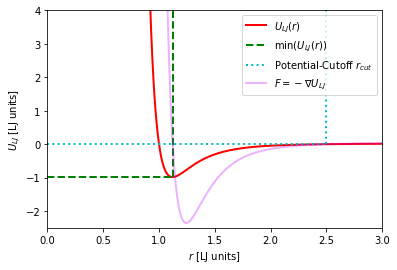

In [8]:
# Plot of the Lennard-Jones potential
plt.figure(0)
x = np.arange(0.01,3.0,step=0.01)

plt.plot(x,U(x), 'r', lw=2.0, label=r'$U_{LJ}(r)$')
plt.plot([0,2**(1./6.)*sigma],[np.min(U(x)), np.min(U(x))], 'g--', lw=2.0, label=r"min($U_{LJ}(r)$)")
plt.plot([2**(1./6.)*sigma,2**(1./6.)*sigma], [np.min(U(x)),5], "g--", lw=2.0)
plt.plot([rcut,rcut],[0, 5], 'c:', lw=2.0, label=r"Potential-Cutoff $r_{cut}$")
plt.plot([0,rcut],[0, 0], 'c:', lw=2.0)
plt.plot(x,-DU(x), 'xkcd:bright purple', lw=2.0, label=r'$F=-\nabla U_{LJ}$', alpha=0.3)

plt.axis([0,3.*sigma, -2.5*epsilon, 4])
plt.xlabel(r'$r$ [LJ units]')
plt.ylabel(r'$U_{LJ}$ [LJ units]')
plt.legend(loc='upper right')
plt.show()

### 3. Define a class containing the neccessary information of all particles.

*The class should contain **particle indices, spatial coordinates, velocities, accelerations and forces.** It should also a) initialize the arrays holding the particles and b) have a function to distribute the particle in the box (e.g. on a grid) and to assign starting velocities (e.g. randomly distributes velocities). At the least, the particle positions should not overlap.*

In [22]:
class Atom:
    """ Class Atom represents and manipulates atom types, coordinates etc. """
        
    def __init__(self, N_=10):
        # initialization method, like a constructur in C++
        self.ind = np.arange(N)
        self.r = np.zeros((N_,3), dtype=np.float64)
        self.v = np.zeros((N_,3), dtype=np.float64)
        self.a = np.zeros((N_,3), dtype=np.float64)
        self.f = np.zeros((N_,3), dtype=np.float64)
        
    def initializeMD(self):
        # put atoms on a lattice and assign velocity
        gridstep = 1.0
        x = 0
        y = 4
        z = 4        
        for idx, row in enumerate(self.r):
            # put atoms on a simple grid, nothing special
            self.r[idx,:] = [0.1+x*gridstep, 0.1+y*gridstep, 0.1+z*gridstep]
            x += 1;
            if x == np.floor(L/gridstep):
                x = 0
                y += 1
            if y == np.floor(L/gridstep):
                y=0
                z+=1;   
            
        # set random velocities
        self.v = 2.5*(np.random.random_sample(np.shape(self.v))-0.5)

### (Optional visual test -  looking at a 3D plot of the particles in the simulation box)

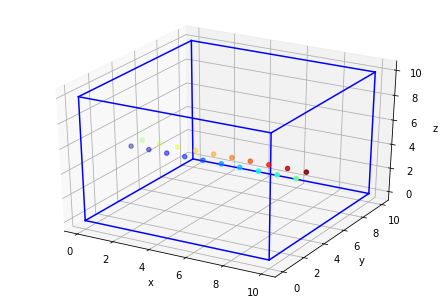

In [23]:
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D

# new Atom class instance
Cheese = Atom(N)
Cheese.initializeMD()

fig = plt.figure(1)
ax = Axes3D(fig)

# draw box 
ax.plot([0,0],[0,L],[0,0],'b-')
ax.plot([0,L],[0,0],[0,0],'b-')
ax.plot([L,L],[L,0],[0,0],'b-')
ax.plot([L,0],[L,L],[0,0],'b-')
ax.plot([0,0],[0,L],[L,L],'b-')
ax.plot([0,L],[0,0],[L,L],'b-')
ax.plot([L,L],[L,0],[L,L],'b-')
ax.plot([L,0],[L,L],[L,L],'b-')
ax.plot([0,0],[0,0],[0,L],'b-')
ax.plot([L,L],[0,0],[0,L],'b-')
ax.plot([0,0],[L,L],[0,L],'b-')
ax.plot([L,L],[L,L],[0,L],'b-')

# define color gradient
col=cm.jet(np.linspace(0,1,N))

# draw circles at particle posiitons
ax.scatter(Cheese.r[:,0], Cheese.r[:,1], Cheese.r[:,2], marker="o", color=col)
   
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

### Short excursion into periodic boundary conditions

Our LJ fluid is supposed to be inside a box with periodic boundary conditions (PBC). **In MD simulations this means taking into account two principles.**
<br>

1. **Periodic Boundary Conditions "per se"** - Particles that leave the box on one side (dimension) need to reenter the same box on the other side.

<center>(Image source: doi:10.1002/wcms.1358)</center>
<img src="img/pbc.jpg" width=200 />


2. **Minimum Image Convention** - Particle distances (and hence, forces) need to be evaluated between the nearest (!) images of these particles.

<center>(Image source: https://freidok.uni-freiburg.de/data/1506) </center>
<img src="img/mic.jpg" width=250 />


We need to implement this in the right parts of the program as part of the time integration routine. Let us therefore focus on this part next.

### 4. Write the functions which calculate positions, velocities, accelerations and forces at a new timestep. We will later call them in the main loop to implement the Velocity-Verlet algorithm.

***4a)*** *At first, let us write the three functions update_pos, update_vel and update_acc according to the Velocity-Verlet algorithm. Keep in mind the periodic boundary conditions for update_pos!*

In [24]:
def update_pos(r, v, a):
    """ Updates particle positions and enforces PBC """
    
    r += v*dt + 0.5*dt*dt*a
    
    # Enforce periodic boundary conditions
    r[r >= L] -= L
    r[r < 0] += L
    return r

def update_vel(v,a,f):
    """ Updates particle velocities """
    v += 0.5*dt*(f/m + a)
    return v

def update_acc(a,f):
    """ Updates particle accelerations """
    a  = f/m
    return a

***4b)*** *Next, we will write the function update_force. Here, the forces between all pairs of particles are calculated. This part typically consumes the most CPU time. (Optional: It is practical to also calculate potential energy and the virial for the pressure calculation at this point.)*

In [25]:
def calc_distances(r, cutoff_):
    """ Calculate distances of all pairs within the cutoff radius."""
    
    # to consider all atom pairs we generate a vector of all pair indices
    pairs = np.array([(i,j) for i in range(N) for j in range(i)])
    
    # calculate distances between all pairs
    i = pairs[:,0]
    j = pairs[:,1]
    dr = r[i,:] -  r[j,:]
    
    # enforce minimum image convention!
    dr[dr > 0.5*L] -= L
    dr[dr <= -0.5*L] += L
    
    # get absolute distances of all pairs
    dr_abs = np.sqrt((dr * dr).sum(axis=1))
    
    # only pairs within the cutoff will interact, ignore all other pairs
    pairs_inside = dr_abs < cutoff_
    pairs = pairs[pairs_inside,:] 
    dr = dr[pairs_inside,:]
    dr_abs = dr_abs[pairs_inside]    
    
    return pairs, dr, dr_abs
    
def calc_bond_distances(r, bonds, cutoff_):
    """ Calculate distances of all bonded pairs."""
    
    # to consider all atom pairs we generate a vector of all pair indices
    #pairs = np.array([(i,j) for i in range(N) for j in range(i)])
    #print(bonds)
    #print(bonds[:,0])
    #print(bonds[:,1])
    #print(bonds[:,0] )
    
    # calculate distances between all pairs
    i = bonds[:,0]
    j = bonds[:,1]
    dr = r[i,:] -  r[j,:]
    
    # enforce minimum image convention!
    dr[dr > 0.5*L] -= L
    dr[dr <= -0.5*L] += L
    
    # get absolute distances of all pairs
    dr_abs = np.sqrt((dr * dr).sum(axis=1))
    
    # only pairs within the cutoff will interact, ignore all other pairs
    bonds_inside = dr_abs < cutoff_
    
    #if np.shape(bonds[bonds_inside,:]) != np.shape(bonds[:,:]):
    #    print("A bond is too long!!!")
    
    bonds = bonds[bonds_inside,:] 
    dr = dr[bonds_inside,:]
    dr_abs = dr_abs[bonds_inside]    
    
    return bonds, dr, dr_abs    
    

In [26]:
def update_force(r,f):
    """ Calculates forces between pairs of particles, as well as potential energy and pressure."""
    
    global virial
    virial = 0.0

    # reset forces to zero
    f[:,:] = 0
    
    # get pair indices, (vector) pair separations, and absolute pair distances 
    # only for pairs inside the cutoff
    pairs, dr, dr_abs = calc_bond_distances(r, pairs_global, rcut)

    # Force = - dU / dr (negative Derivative of Potential)
    # First, we calculate the magnitudes of the forces
    f_abs = DU(dr_abs)
    
    # apply the forces due to non-bonded interactions on the atoms
    for k, idx  in enumerate(pairs):
        i = idx[0]
        j = idx[1]      
        
        # force-vector = force-magnitude * unit distance vector between pair
        force = f_abs[k] * (dr[k,:]/dr_abs[k])
        
        #Newton's 3rd law: actio = reactio
        f[i,:] -= force
        f[j,:] += force
        virial += np.dot(force,dr[k,:])
        
    # apply the forces due to bonded interactions on the atoms 
    _, dr, dr_abs = calc_bond_distances(r, bonds, L*0.5)
    
    # magnitude of forces due to bonds
    f_abs = DHARM(dr_abs)
    #f_abs = DFENE(dr_abs)
    
    #print(dr_abs.shape)
    #print(f_abs.shape)
    
    for k, idx  in enumerate(bonds):
        i = idx[0]
        j = idx[1]      
        #print(i, j)
        
        # force-vector = force-magnitude * unit distance vector between pair
        force = f_abs[k] * (dr[k,:]/dr_abs[k])
        
        #Newton's 3rd law: actio = reactio
        f[i,:] -= force
        f[j,:] += force
        virial += np.dot(force,dr[k,:])
        
    return f   

Let's think about how potential energy, kinetic energy, temperature etc. are calculated in MD simulations.

#### Potential Energy:

The potential energy is the sum of the all particle interactions due to the interaction potential (and possible contributions from external potentials),

\begin{equation} E_\mathrm{pot} = \sum_{i<j} U_\mathrm{LJ}\left(r_{ij}\right). \end{equation}


#### Kinetic Energy:

The system's kinetic energy is the sum of the kinetic energies of all particles,

\begin{equation} E_\mathrm{kin} = \sum_i^N \frac{m_i v_i^2}{2}. \end{equation}


#### Temperature

Temperature is evaluated based on the **equipartition theorem**: $ \langle E_\mathrm{kin} \rangle = \frac{3}{2} N k_\mathrm{B} T. $ (Here, in LJ units, $k_\mathrm{B} = 1$). It follows

\begin{equation} T =  \frac{2}{3N} \langle E_\mathrm{kin} \rangle \end{equation}.

#### Pressure:

Pressure in MD simulations can be forumlated in the form of the so-called **virial equation** (see e.g. Hansen & McDonald "Theory of Simple Liquids", Chapter 2.2 for more details where this is coming from).

\begin{equation} P =  \frac{N k_\mathrm{B} T}{V}  + \frac{1}{3V}  \langle \sum_{i<j} \vec{F_{ij}} \cdot \vec{r_{ij}} \rangle . \end{equation}


### 5. Write a function called *compute*, that calculates thermodynamic observables from atomistic information at certain time steps and prints them to the screen.

*The function compute is meant to calculate and output information like **temperature, kinetic energy, potential energy, total energy, pressure and average particle velocity.** This function will only to be called at specific times, e.g. every 100 time steps, and not at every step like the time integration.*

In [27]:
def compute(step, r, v):
    """ Calculates and displays thermodynamic observables (scalars)"""
    
    
    # Get absolute pair distances
    #_, _, dr_abs = calc_distances(r, rcut)
    _, _, dr_abs = calc_bond_distances(r, pairs_global, rcut)
    
    # Potential energy 
    E_nonbond = np.sum(U(dr_abs))
    
    _, _, dr_abs = calc_bond_distances(r, bonds, L*0.5)
    
    # Get bonded pair_distances
    E_bond = np.sum(HARM(dr_abs))
    #E_bond = np.sum(FENE(dr_abs))
    
    Epot = E_nonbond + E_bond
    
    # Squared and Absolute velocities (array)
    vsq = ((v * v).sum(axis=1))
    vabs = np.sqrt(vsq)
    
    # Average velocity of particles
    meanvel = 1.0*np.mean(vabs)
    
    # Kinetic Energy
    Ekin = 0.5*m*np.sum(vsq)
    
    # Temperature
    T = 2.0*Ekin/(N*3.0)
    
    # pressure = N*k_b*T/V + virial/(dimensions*V)
    P = 1.0*N*T/V + virial/(3*V)
    
    # output thermodynam. info
    if step == 0:
        print("  Step\tTemp\tEpot\tEkin\tEtot\tMeanVel\tPress".expandtabs(10))    
    print("%6d\t%3.4f\t%3.4f\t%3.4f\t%3.4f\t%3.4f\t%3.4f".expandtabs(8) % (step, T, Epot, Ekin, Ekin+Epot,  meanvel, P))

### (Optional: Write out the particle trajectory in the xyz-Format. The resulting file can be watched like a film in programs like VMD, etc.)

*xyz is a relatively simple format. You can use Google to find out how the format is structured.*

In [28]:
def movie(switch, r):
    """ Write film in XYZ format and save to file. """
    global file
    
    # open file in the beginning
    if switch==0:
        filename = "film.xyz"
        file = open(filename, "w")

    # write out coordinates of current snapshot
    elif switch==1:
        file.write("%s\n" % (N))
        file.write("atom x y z\n")
        for atom in r:
            file.write("H %s\t%s\t%s\n" % (atom[0], atom[1], atom[2]))

    # close the file in the end
    elif switch==2:
        file.close()

### (Optional: Calculate the radial distribution function (rdf), also known as pair correlation function g(r) of the system.)

*The rdf describes the probability to find a particle at a distance r from a reference particle at zero. In principle, the rdf is a histogram over the particle distance. The bins of the histogram are shere shells around the reference particle in the center (at r=0). The histogram is normalized by "comparing" the system to an ideal gas with equivalent density as a reference system. At large distances r the rdf typically goes towards 1.*

<center>(Image source: http://isaacs.sourceforge.net/manual/page23_ct.html)</center>
<img src="img/rdf.png" width=200 />

In [29]:
def rdf(switch, r):
    """ Calculate, plot and save radial distribution function g(r) """
    global rdf_count
    global g
    global gbins, gbin_id, gbin_center, binsz

    # initialize values, vectors
    if switch == 0:
        
        binsz = 0.1 # bin size
        gbins = int(L/2.0/binsz) # max. number of bins
        gbin_id = np.arange(gbins) # bin indices
        gbin_center = binsz*(gbin_id+0.5) # bin centers in distance units
        
        rdf_count = 0 # number of measurements
        g = np.zeros(gbins) # the function g(r)

    # calculate rdf histogram (counts)     
    elif switch == 1:
        
        g_local = np.zeros(gbins)
        
        # get pair indices and distance of all pairs
        pairs, _, dr_abs = calc_distances(r, L*0.5)

        # binning the data = generate the histogram
        for k, idx in enumerate(pairs):
            index = int(dr_abs[k]/binsz) 
            g_local[index] += 2
            
        g = np.add(g, g_local)
        rdf_count += 1

    # normalize histogram, plot and save to a file
    elif switch == 2:
        
        # normalize the bins
        for j in range(gbins):
            # volume of the jth shell
            v_shell =  np.pi*(4.0/3.0)*((j+1)*(j+1)*(j+1) - j*j*j)*binsz*binsz*binsz
            g[j] /= rdf_count*v_shell*N*rho 

        # plot and save to a file
        plt.figure(2)
        plt.plot(gbin_center, g)
        plt.savefig("rdf.png", dpi=200)

        # save values to a file
        rdfdata = zip(gbin_id, gbin_center, g)
        np.savetxt('rdf.txt', list(rdfdata), fmt='%f', header='bin-nr bin-center(r) g(r)')

Next comes the main time loop of the program. Here, the MD code is performing its job, i.e. an instance of the Atom class is created, and initial setup is created and then the time integration is performed interatively using the Velocity-Verlet algorithm. Additionally, some thermodynamic output is generated and further functionalities can be evoked as well.

### 6. Implement the Velocity-Verlet algorithm in the main loop and print thermodynamic information to the screen regularly, e.g. every 100 steps.
*Make sure to call update_pos, update_vel, update_acc and update_force in the suitable order. You can use if statements to call functions only at certain times.*


In [30]:
%%time

# main loop of the program
for j in range(nsteps+1):
    
    # Initialize System at time zero
    if j == 0:
        Peter = Atom(N)
        Peter.initializeMD()
        movie(0, Peter.r)
        rdf(0, Peter.r)
    else:
        # at all other times: time integration via Velocity-Verlet
        Peter.r = update_pos(Peter.r, Peter.v, Peter.a)
      
    Peter.f = update_force(Peter.r, Peter.f)
    Peter.v = update_vel(Peter.v, Peter.a, Peter.f)
    Peter.a = update_acc(Peter.a, Peter.f)

    # regular calculation & output of thermodynamic info
    if j%1000 == 0:
        compute(j, Peter.r, Peter.v)
        
    # write out a frame of a movie regularly
    if j%200 == 0:
        movie(1, Peter.r)
    
    # generate rdf from separate snapshots
    if (j%200 == 0 and j > 5000):
        rdf(1, Peter.r)

# after the simulation generate plots or write, save and close files
movie(2, Peter.r)
rdf(2, Peter.r)


  Step    Temp      Epot      Ekin      Etot      MeanVel   Press
     0     0.5993   -9.1468   17.9782   8.8314   1.3084   -0.2112
  1000     0.6415   -9.2922   19.2453   9.9531   1.2932   0.0688
  2000     0.7772   -13.2903   23.3147   10.0243   1.4625   0.0789
  3000     0.9709   -19.3969   29.1259   9.7290   1.5845   0.0213
  4000     0.8944   -17.1441   26.8314   9.6874   1.4932   0.0152
  5000     0.8999   -17.5344   26.9972   9.4628   1.5256   0.0584
  6000     1.1619   -25.7629   34.8568   9.0938   1.7608   0.0140
  7000     0.9325   -18.7140   27.9754   9.2615   1.5799   0.0180
  8000     0.8428   -15.9063   25.2836   9.3773   1.4589   0.0272
  9000     1.0378   -21.8025   31.1329   9.3305   1.6510   0.0164
 10000     1.0255   -21.5248   30.7663   9.2415   1.5759   0.0429
 11000     0.9024   -17.7475   27.0713   9.3237   1.5396   0.0631
 12000     0.9847   -20.4531   29.5406   9.0875   1.5675   0.0604
 13000     1.1199   -24.6017   33.5962   8.9945   1.6891   0.0610
 14000    

KeyboardInterrupt: 

### 7. (Optional) Now the program should be fully functional, at least in a simple way - particles are moving and some output is generated. Pick a task to further extend the code:
*Here are a few ideas that could be implemented:*

* Calculate and output **pressure of the sytem.**
* Write out a **movie in the xyz format.** Files of this format can be opened with visualization software like VMD and others. Then you can watch the moving particles on your screen. This can also be helpful to check for (visible) misbehaviors of the system.
* Calculate the **radial distribution function g(r)** of the LJ fluid
* other ideas - implement a simple thermostat, generate a velocity histogram, your own idea, ...